In [152]:
import torch
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import numpy as np
import json
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
import time
import os
import copy
import random

In [153]:
batch_size  = 512
random_seed = 888
random.seed(random_seed)
torch.manual_seed(random_seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [154]:
data_path = './dataset/'
texture_dataset = datasets.ImageFolder(
    data_path,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]))

In [155]:
train_idx, val_idx = train_test_split(list(range(len(texture_dataset))), test_size=0.2, random_state=random_seed)
datasets = {}
datasets['train'] = Subset(texture_dataset, train_idx)
datasets['valid'] = Subset(texture_dataset, val_idx)

In [156]:
dataloaders, batch_num = {}, {}
dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'],
                                                   batch_size=batch_size, shuffle=True,
                                                   num_workers=4)
dataloaders['valid'] = torch.utils.data.DataLoader(datasets['valid'],
                                                   batch_size=batch_size, shuffle=False,
                                                   num_workers=4)

batch_num['train'], batch_num['valid'] = len(dataloaders['train']), len(dataloaders['valid'])
print('batch_size : %d,  tvt : %d / %d' % (batch_size, batch_num['train'], batch_num['valid']))

batch_size : 512,  tvt : 4 / 1


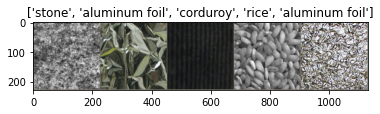

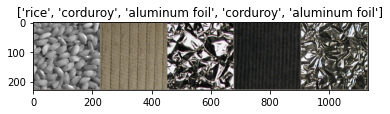

In [146]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

num_show_img = 5

class_names = {
    "0": "aluminum foil",
    "1": "brick",
    "2": "corduroy",
    "3": "fur",
    "4": "rice",
    "5": "stone",
    "6": "wood"
}

# train check
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# valid check
inputs, classes = next(iter(dataloaders['valid']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])

In [157]:
def WaveletTransformAxisY(batch_img):
    odd_img  = batch_img[:,0::2]
    even_img = batch_img[:,1::2]
    L = (odd_img + even_img) / 2.0
    H = torch.abs(odd_img - even_img)

    return L, H

In [158]:
def WaveletTransformAxisX(batch_img):
    # transpose + fliplr
    tmp_batch = torch.permute(batch_img, (0, 2, 1))
    tmp_batch = torch.fliplr(tmp_batch)
    _dst_L, _dst_H = WaveletTransformAxisY(tmp_batch)
    # transpose + flipud
    dst_L = torch.permute(_dst_L, [0, 2, 1])
    dst_L = torch.flipud(dst_L)
    dst_H = torch.permute(_dst_H, [0, 2, 1])
    dst_H = torch.flipud(dst_H)

    return dst_L, dst_H

In [159]:
def Wavelet(batch_image):
    r = batch_image[:,0]
    g = batch_image[:,1]
    b = batch_image[:,2]

    # level 1 decomposition
    wavelet_L, wavelet_H = WaveletTransformAxisY(r)
    r_wavelet_LL, r_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    r_wavelet_HL, r_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(g)
    g_wavelet_LL, g_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    g_wavelet_HL, g_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(b)
    b_wavelet_LL, b_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    b_wavelet_HL, b_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_data = [r_wavelet_LL, r_wavelet_LH, r_wavelet_HL, r_wavelet_HH,
                    g_wavelet_LL, g_wavelet_LH, g_wavelet_HL, g_wavelet_HH,
                    b_wavelet_LL, b_wavelet_LH, b_wavelet_HL, b_wavelet_HH]
    transform_batch = torch.stack(wavelet_data, axis=1)

    # level 2 decomposition
    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(r_wavelet_LL)
    r_wavelet_LL2, r_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    r_wavelet_HL2, r_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(g_wavelet_LL)
    g_wavelet_LL2, g_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    g_wavelet_HL2, g_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(b_wavelet_LL)
    b_wavelet_LL2, b_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    b_wavelet_HL2, b_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)


    wavelet_data_l2 = [r_wavelet_LL2, r_wavelet_LH2, r_wavelet_HL2, r_wavelet_HH2,
                       g_wavelet_LL2, g_wavelet_LH2, g_wavelet_HL2, g_wavelet_HH2,
                       b_wavelet_LL2, b_wavelet_LH2, b_wavelet_HL2, b_wavelet_HH2]
    transform_batch_l2 = torch.stack(wavelet_data_l2, dim=1)

    # level 3 decomposition
    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(r_wavelet_LL2)
    r_wavelet_LL3, r_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    r_wavelet_HL3, r_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(g_wavelet_LL2)
    g_wavelet_LL3, g_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    g_wavelet_HL3, g_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL2)
    b_wavelet_LL3, b_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    b_wavelet_HL3, b_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_data_l3 = [r_wavelet_LL3, r_wavelet_LH3, r_wavelet_HL3, r_wavelet_HH3,
                       g_wavelet_LL3, g_wavelet_LH3, g_wavelet_HL3, g_wavelet_HH3,
                       b_wavelet_LL3, b_wavelet_LH3, b_wavelet_HL3, b_wavelet_HH3]
    transform_batch_l3 = torch.stack(wavelet_data_l3, dim=1)

    # level 4 decomposition
    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(r_wavelet_LL3)
    r_wavelet_LL4, r_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    r_wavelet_HL4, r_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(g_wavelet_LL3)
    g_wavelet_LL4, g_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    g_wavelet_HL4, g_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(b_wavelet_LL3)
    b_wavelet_LL4, b_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    b_wavelet_HL4, b_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)


    wavelet_data_l4 = [r_wavelet_LL4, r_wavelet_LH4, r_wavelet_HL4, r_wavelet_HH4,
                       g_wavelet_LL4, g_wavelet_LH4, g_wavelet_HL4, g_wavelet_HH4,
                       b_wavelet_LL4, b_wavelet_LH4, b_wavelet_HL4, b_wavelet_HH4]
    transform_batch_l4 = torch.stack(wavelet_data_l4, dim=1)

    return [transform_batch, transform_batch_l2, transform_batch_l3, transform_batch_l4]

In [160]:
class Wavelet_Model(torch.nn.Module):
    def __init__(self):
        super(Wavelet_Model, self).__init__()
        self.conv_1 = nn.Conv2d(12, 64, kernel_size=(3, 3), padding=1)
        self.norm_1 = nn.BatchNorm2d(64)
        self.relu_1 = nn.ReLU()

        self.conv_1_2 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=1)
        self.norm_1_2 = nn.BatchNorm2d(64)
        self.relu_1_2 = nn.ReLU()
        #################################################################################################
        self.conv_a = nn.Conv2d(12, 64, kernel_size=(3, 3), padding=1)
        self.norm_a = nn.BatchNorm2d(64)
        self.relu_a = nn.ReLU()
        #################################################################################################
        self.conv_2 = nn.Conv2d(128, 128, kernel_size=(3, 3), padding=1)
        self.norm_2 = nn.BatchNorm2d(128)
        self.relu_2 = nn.ReLU()

        self.conv_2_2 = nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=1)
        self.norm_2_2 = nn.BatchNorm2d(128)
        self.relu_2_2 = nn.ReLU()
        #################################################################################################
        self.conv_b = nn.Conv2d(12, 128, kernel_size=(3, 3), padding=1)
        self.norm_b = nn.BatchNorm2d(128)
        self.relu_b = nn.ReLU()

        self.conv_b_2 = nn.Conv2d(128, 128, kernel_size=(3, 3), padding=1)
        self.norm_b_2 = nn.BatchNorm2d(128)
        self.relu_b_2 = nn.ReLU()
        #################################################################################################
        self.conv_3 = nn.Conv2d(256, 256, kernel_size=(3, 3), padding=1)
        self.norm_3 = nn.BatchNorm2d(256)
        self.relu_3 = nn.ReLU()

        self.conv_3_2 = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=1)
        self.norm_3_2 = nn.BatchNorm2d(256)
        self.relu_3_2 = nn.ReLU()
        #################################################################################################
        self.conv_c = nn.Conv2d(12, 256, kernel_size=(3, 3), padding=1)
        self.norm_c = nn.BatchNorm2d(256)
        self.relu_c = nn.ReLU()

        self.conv_c_2 = nn.Conv2d(256, 256, kernel_size=(3, 3), padding=1)
        self.norm_c_2 = nn.BatchNorm2d(256)
        self.relu_c_2 = nn.ReLU()

        self.conv_c_3 = nn.Conv2d(256, 256, kernel_size=(3, 3), padding=1)
        self.norm_c_3 = nn.BatchNorm2d(256)
        self.relu_c_3 = nn.ReLU()
        #################################################################################################
        self.conv_4 = nn.Conv2d(512, 256, kernel_size=(3, 3), padding=1)
        self.norm_4 = nn.BatchNorm2d(256)
        self.relu_4 = nn.ReLU()

        self.conv_4_2 = nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=1)
        self.norm_4_2 = nn.BatchNorm2d(128)
        self.relu_4_2 = nn.ReLU()
        #################################################################################################
        self.conv_5 = nn.Conv2d(128, 128, kernel_size=(3, 3), padding=1)
        self.norm_5 = nn.BatchNorm2d(128)
        self.relu_5 = nn.ReLU()

        self.pool_5 = nn.AvgPool2d(kernel_size=(7,7), stride=1, padding=1)
        self.flat_5 = nn.Flatten()

        self.fc_5 = nn.Linear(1152, 2048)
        self.norm_5_1 = nn.BatchNorm1d(2048)
        self.relu_5_1 = nn.ReLU()
        self.drop_5 = nn.Dropout(0.5)
        #################################################################################################
        self.fc_6 = nn.Linear(2048, 7)
        self.norm_6 = nn.BatchNorm1d(7)
        self.relu_6 = nn.ReLU()
        self.drop_6 = nn.Dropout(0.5)
        #################################################################################################
        self.output_fc = nn.Linear(7, 7)

    def forward(self, x):
        input_l1, input_l2, input_l3, input_l4 = Wavelet(x)
        #################################################################################################
        # print('input shape: ', input_l1.shape)
        out_1 = self.conv_1(input_l1)
        # print('conv_1 output shape: ', out_1.shape)
        out_1 = self.norm_1(out_1)
        out_1 = self.relu_1(out_1)

        out_1 = self.conv_1_2(out_1)
        # print('conv_1_2 output shape: ', out_1.shape)
        out_1 = self.norm_1_2(out_1)
        out_1 = self.relu_1_2(out_1)
        #################################################################################################
        out_2 = self.conv_a(input_l2)
        # print('conv_a output shape: ', out_2.shape)
        out_2 = self.norm_a(out_2)
        out_2 = self.relu_a(out_2)

        cat_2 = torch.cat((out_1, out_2), 1)
        # print('concatenate result: ', cat_2.shape)
        out_2 = self.conv_2(cat_2)
        # print('conv_2 output shape: ', out_2.shape)
        out_2 = self.norm_2(out_2)
        out_2 = self.relu_2(out_2)

        out_2 = self.conv_2_2(out_2)
        # print('conv_2_2 output shape: ', out_2.shape)
        out_2 = self.norm_2_2(out_2)
        out_2 = self.relu_2_2(out_2)
        #################################################################################################
        out_3 = self.conv_b(input_l3)
        # print('conv_b output shape: ', out_3.shape)
        out_3 = self.norm_b(out_3)
        out_3 = self.relu_b(out_3)

        out_3 = self.conv_b_2(out_3)
        # print('conv_b_2 output shape: ', out_3.shape)
        out_3 = self.norm_b_2(out_3)
        out_3 = self.relu_b_2(out_3)
        #################################################################################################
        cat_3 = torch.cat((out_2, out_3), 1)
        # print('concatenate result: ', cat_3.shape)
        out_3 = self.conv_3(cat_3)
        # print('conv_3 output shape: ', out_3.shape)
        out_3 = self.norm_3(out_3)
        out_3 = self.relu_3(out_3)

        out_3 = self.conv_3_2(out_3)
        # print('conv_3_2 output shape: ', out_3.shape)
        out_3 = self.norm_3_2(out_3)
        out_3 = self.relu_3_2(out_3)
        #################################################################################################
        out_4 = self.conv_c(input_l4)
        # print('conv_c output shape: ', out_4.shape)
        out_4 = self.norm_c(out_4)
        out_4 = self.relu_c(out_4)

        out_4 = self.conv_c_2(out_4)
        # print('conv_c_2 output shape: ', out_4.shape)
        out_4 = self.norm_c_2(out_4)
        out_4 = self.relu_c_2(out_4)

        out_4 = self.conv_c_3(out_4)
        # print('conv_c_3 output shape: ', out_4.shape)
        out_4 = self.norm_c_3(out_4)
        out_4 = self.relu_c_3(out_4)
        #################################################################################################
        cat_4 = torch.cat((out_3, out_4), 1)
        # print('concatenate result: ', cat_4.shape)
        out_4 = self.conv_4(cat_4)
        # print('conv_4 output shape: ', out_4.shape)
        out_4 = self.norm_4(out_4)
        out_4 = self.relu_4(out_4)

        out_4 = self.conv_4_2(out_4)
        # print('conv_4_2 output shape: ', out_4.shape)
        out_4 = self.norm_4_2(out_4)
        out_4 = self.relu_4_2(out_4)
        #################################################################################################
        out_5 = self.conv_5(out_4)
        # print('conv_5 output shape: ', out_5.shape)
        out_5 = self.norm_5(out_5)
        out_5 = self.relu_5(out_5)

        out_5 = self.pool_5(out_5)
        out_5 = self.flat_5(out_5)
        #################################################################################################
        out_5 = self.fc_5(out_5)
        # print('fc_5 output shape: ', out_5.shape)
        out_5 = self.norm_5_1(out_5)
        out_5 = self.relu_5_1(out_5)
        out_5 = self.drop_5(out_5)

        out_6 = self.fc_6(out_5)
        # print('fc6 output shape: ', out_6.shape)
        out_6 = self.norm_6(out_6)
        out_6 = self.relu_6(out_6)
        out_6 = self.drop_6(out_6)
        #################################################################################################
        output = self.output_fc(out_6)

        return output

In [161]:
model = Wavelet_Model().to(device)

In [162]:
since = time.time()

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
train_loss, train_acc, valid_loss, valid_acc = [], [], [], []

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr = 0.001)

lmbda = lambda epoch: 0.98739
exp_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)
num_epochs=100

In [ ]:
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch + 1, num_epochs))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'valid']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss, running_corrects, num_cnt = 0.0, 0, 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            num_cnt += len(labels)
        if phase == 'train':
            exp_lr_scheduler.step()

        epoch_loss = float(running_loss / num_cnt)
        epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)

        if phase == 'train':
            train_loss.append(epoch_loss)
            train_acc.append(epoch_acc)
        else:
            valid_loss.append(epoch_loss)
            valid_acc.append(epoch_acc)
        print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))

        # deep copy the model
        if phase == 'valid' and epoch_acc > best_acc:
            best_idx = epoch
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            #                 best_model_wts = copy.deepcopy(model.module.state_dict())
            print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

# load best model weights
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), 'Wavelet_cnn.pt')
print('model saved')

Epoch 1/100
----------
train Loss: 2.05 Acc: 19.8
valid Loss: 1.90 Acc: 48.1
==> best model saved - 0 / 48.1
Epoch 2/100
----------
train Loss: 1.68 Acc: 36.4
valid Loss: 1.55 Acc: 62.1
==> best model saved - 1 / 62.1
Epoch 3/100
----------
train Loss: 1.57 Acc: 41.0
valid Loss: 1.31 Acc: 68.6
==> best model saved - 2 / 68.6
Epoch 4/100
----------
train Loss: 1.53 Acc: 43.4
valid Loss: 1.34 Acc: 63.3
Epoch 5/100
----------
train Loss: 1.51 Acc: 47.0
valid Loss: 1.32 Acc: 63.3
Epoch 6/100
----------
train Loss: 1.48 Acc: 50.0
valid Loss: 1.27 Acc: 65.6
Epoch 7/100
----------
train Loss: 1.44 Acc: 51.3
valid Loss: 1.30 Acc: 66.6
Epoch 8/100
----------
train Loss: 1.45 Acc: 51.3
valid Loss: 1.28 Acc: 69.1
==> best model saved - 7 / 69.1
Epoch 9/100
----------
train Loss: 1.44 Acc: 53.1
valid Loss: 1.27 Acc: 70.8
==> best model saved - 8 / 70.8
Epoch 10/100
----------
train Loss: 1.41 Acc: 54.6
valid Loss: 1.22 Acc: 72.8
==> best model saved - 9 / 72.8
Epoch 11/100
----------
train Loss: 1

No handles with labels found to put in legend.


best model : 14 - 88 / 0.3


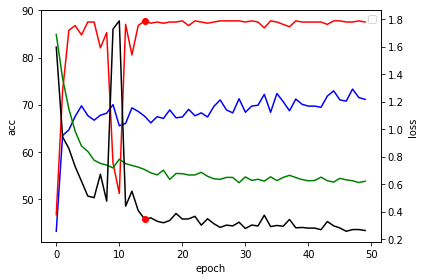

In [100]:
print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-')
ax1.plot(valid_acc, 'r-')
plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-')
ax2.plot(valid_loss, 'k-')
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')

fig.tight_layout()
plt.legend()
plt.show()

In [105]:
img = Image.open('./test_samples/brick.jpg')
tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()])
img = tf(img)
img = img.unsqueeze(0)
print(img.shape)

torch.Size([1, 3, 224, 224])


In [106]:
model = Wavelet_Model()
model.load_state_dict(torch.load('./Wavelet_cnn.pt'))
model.eval()

Wavelet_Model(
  (conv_1): Conv2d(12, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_1): ReLU()
  (conv_1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (norm_1_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_1_2): ReLU()
  (conv_a): Conv2d(12, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_a): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_a): ReLU()
  (conv_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_2): ReLU()
  (conv_2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (norm_2_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_2_2): ReLU()
  (conv_b): Conv2d(12,

In [107]:
predict = model(img)
score = torch.nn.functional.softmax(predict, dim=1).detach().numpy()

print(predict, score)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[str(np.argmax(score))], 100 * np.max(score))
)

tensor([[-0.7707, -1.3378,  2.0957, -2.9047, -0.8678, -1.9402, -1.7405]],
       grad_fn=<AddmmBackward>) [[0.04794862 0.02719421 0.8426004  0.00567528 0.04351231 0.01488868
  0.01818053]]
This image most likely belongs to corduroy with a 84.26 percent confidence.


In [151]:
def pretty_size(size):
    """Pretty prints a torch.Size object"""
    assert(isinstance(size, torch.Size))
    return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
    """Prints a list of the Tensors being tracked by the garbage collector."""
    import gc
    total_size = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj):
                if not gpu_only or obj.is_cuda:
                    print("%s:%s%s %s" % (type(obj).__name__,
                                          " GPU" if obj.is_cuda else "",
                                          " pinned" if obj.is_pinned else "",
                                          pretty_size(obj.size())))
                    total_size += obj.numel()
            elif hasattr(obj, "data") and torch.is_tensor(obj.data):
                if not gpu_only or obj.is_cuda:
                    print("%s → %s:%s%s%s%s %s" % (type(obj).__name__,
                                                   type(obj.data).__name__,
                                                   " GPU" if obj.is_cuda else "",
                                                   " pinned" if obj.data.is_pinned else "",
                                                   " grad" if obj.requires_grad else "",
                                                   " volatile" if obj.volatile else "",
                                                   pretty_size(obj.data.size())))
                    total_size += obj.data.numel()
        except Exception as e:
            pass
    print("Total size:", total_size)

dump_tensors()

Tensor: GPU pinned 17 × 7
Tensor: GPU pinned 17
Tensor: GPU pinned 17
Tensor: GPU pinned 
Parameter: GPU pinned 64 × 12 × 3 × 3
Parameter: GPU pinned 64
Parameter: GPU pinned 64
Parameter: GPU pinned 64
Parameter: GPU pinned 64 × 64 × 3 × 3
Parameter: GPU pinned 64
Parameter: GPU pinned 64
Parameter: GPU pinned 64
Parameter: GPU pinned 64 × 12 × 3 × 3
Parameter: GPU pinned 64
Parameter: GPU pinned 64
Parameter: GPU pinned 64
Parameter: GPU pinned 128 × 128 × 3 × 3
Parameter: GPU pinned 128
Parameter: GPU pinned 128
Parameter: GPU pinned 128
Parameter: GPU pinned 128 × 128 × 3 × 3
Parameter: GPU pinned 128
Parameter: GPU pinned 128
Parameter: GPU pinned 128
Parameter: GPU pinned 128 × 12 × 3 × 3
Parameter: GPU pinned 128
Parameter: GPU pinned 128
Parameter: GPU pinned 128
Parameter: GPU pinned 128 × 128 × 3 × 3
Parameter: GPU pinned 128
Parameter: GPU pinned 128
Parameter: GPU pinned 128
Parameter: GPU pinned 256 × 256 × 3 × 3
Parameter: GPU pinned 256
Parameter: GPU pinned 256
Paramete

In [148]:
model = None
inputs = None
labels = None

In [149]:
torch.cuda.empty_cache()

In [150]:
Wavelet_Model = None